In [76]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 22

# Solving the skateboard problem numerically

In a previous activity, we learned about the Euler method to numerically solve an ODE -- but it only applies to a 1st order ODE. So we have to rewrite our 2nd order ODE
$$
\dot \phi = -\omega_0^2 \phi
$$
to a system of two coupled 1st order ODEs by introducing $\omega = \dot \phi$:
\begin{eqnarray*}
\frac{d \phi}{dt} &=& \omega\\
\frac{d \omega}{dt} &=& -\omega_0^2 \phi
\end{eqnarray*}

There is some thinking involved in how to use the Euler method for a system of ODEs, but as I showed in class, you basically do the same thing twice, updating both $\phi$ and $\omega$, but the r.h.s function $f(y, t)$ (or whatever it's called for your description of the Euler method) needs to take both $\phi$ and $\omega$.

This is what I came up with in class (well, I added the $\omega_0$ term afterward rather than just assuming $\omega_0 = 1$):

In [137]:
g = 9.8 # m/s^2
L = 5 # m
om0 = (g/L) ** .5
phi0 = 0.5 # initial angle

In [138]:
def f_omega(t, omega, phi): return -om0**2 * phi
def f_phi(t, omega, phi): return omega

t = 0
omega = 0
phi = phi0
dt = 0.1
ts, omegas, phis = [t], [omega], [phi]
for n in range(200):
    omega += dt * f_omega(t, omega, phi)
    phi += dt * f_phi(t, omega, phi)
    t += dt
    ts.append(t)
    omegas.append(omega)
    phis.append(phi)

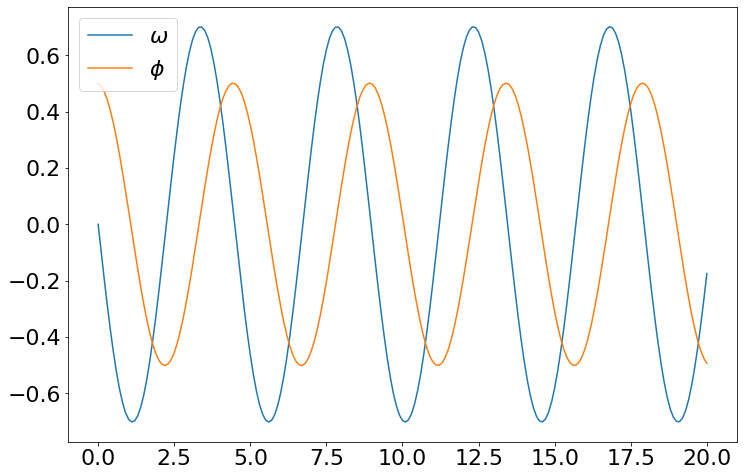

In [139]:
ts, omegas, phis = np.array(ts), np.array(omegas), np.array(phis)
plt.plot(ts, omegas, label="$\omega$")
plt.plot(ts, phis, label="$\phi$")
#plt.plot(ts, np.exp(-ts));
plt.legend();

And well, that worked quite nicely. In fact, too nicely, as I noticed in class, but I only realized the problem afterwards: When I update $\omega$ above, I'm using the r.h.s. based on the old $\omega$ and old $\phi$. But when I update $\phi$, I'm using the rhs based on the new $\omega$ and the old $\phi$. In the Euler method, I really should use the old values always.

What I ended up doing here, inadvertently is to implement some leap-frog type method, which is a bug. It's also a bug which actually makes this numerical integration a lot better than the Euler method ;)

## Doing the Euler method correctly

In [140]:
t = 0
omega = 0
phi = .1
dt = 0.1
ts, omegas, phis = [t], [omega], [phi]
for n in range(200):
    rhs_omega, rhs_phi = f_omega(t, omega, phi), f_phi(t, omega, phi)
    omega += dt * rhs_omega
    phi   += dt * rhs_phi
    t += dt
    ts.append(t)
    omegas.append(omega)
    phis.append(phi)

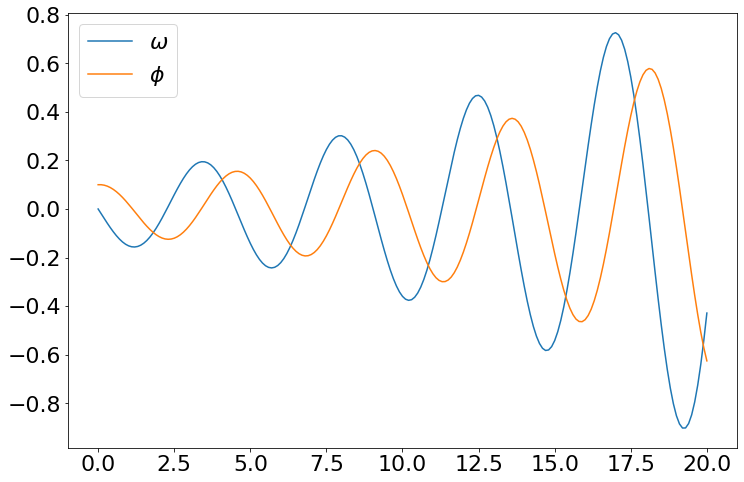

In [141]:
ts, omegas, phis = np.array(ts), np.array(omegas), np.array(phis)
plt.plot(ts, omegas, label="$\omega$")
plt.plot(ts, phis, label="$\phi$")
#plt.plot(ts, np.exp(-ts));
plt.legend();

So yeah, using the Euler method correctly, I have a bit of a problem -- It still captures the sinusoidal behavior correctly, but the amplitude keeps increasing over time, and that definitely doesn't make sense physically (where would the energy come from)? So what happens here is that this method has a substantial numerical error which keeps increasing over time. :(

## Coding things more nicely

The 2nd instance of the code above starts to hint that things could be done more nicely if one put $\omega$ and $\phi$ into a vector,
similary for the r.h.s., etc. That way one can have an Euler method that works for an arbitrary system of 1st order ODEs.

In [142]:
def euler(y0, f, dt, t_final):
    """
    Given the rhs function f(t, y) and initial condition y, uses the 
    Euler method to numerically integrate the ODE dy/dt = f(t, y) from
    0 to t_final using a timestep of dt
    """
    t = np.arange(0, t_final, dt)
    y = np.empty((len(y0), t.shape[0]))
    y[:,0] = y0
    for n in range(len(t)-1):
        rhs = np.asarray(f(t[n], y[:,n]))
        y[:,n+1] = y[:,n] + dt * rhs
    return t, y

Here, we specifically define our system of ODEs for the skateboard problem

In [143]:
# solution vector y = (omega, phi)
# rhs of the ODE we're solving
def f_skateboard(t, y):
    omega, phi = y
    return [-om0**2 * phi, omega]

# initial condition
y0 = [0, phi0]

Now, use the Euler method to solve our ODE using a timestep $\Delta t = 0.1$.

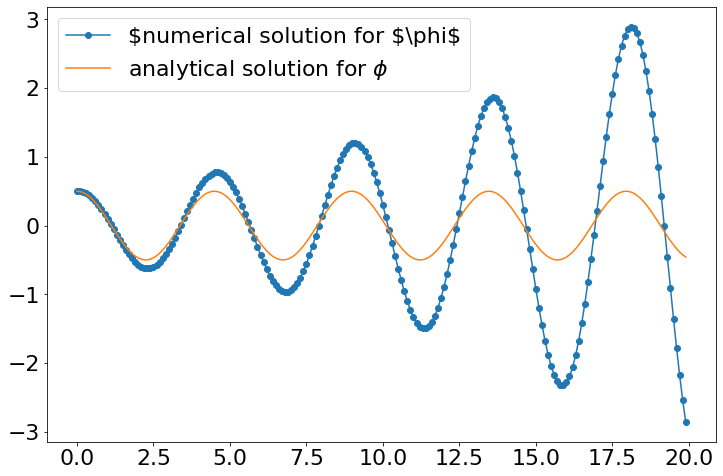

In [144]:
def integrate_and_plot(dt, t_final):
    t, y = euler(y0, f_skateboard, dt, t_final)
    plt.plot(t, y[1,:], '-o', label='$numerical solution for $\phi$');
    plt.plot(t, phi0 * np.cos(om0 * t), label='analytical solution for $\phi$')
    plt.legend()
    
integrate_and_plot(dt=.1, t_final=20)

Let's do it again using a timestep $\Delta t = 0.01$.

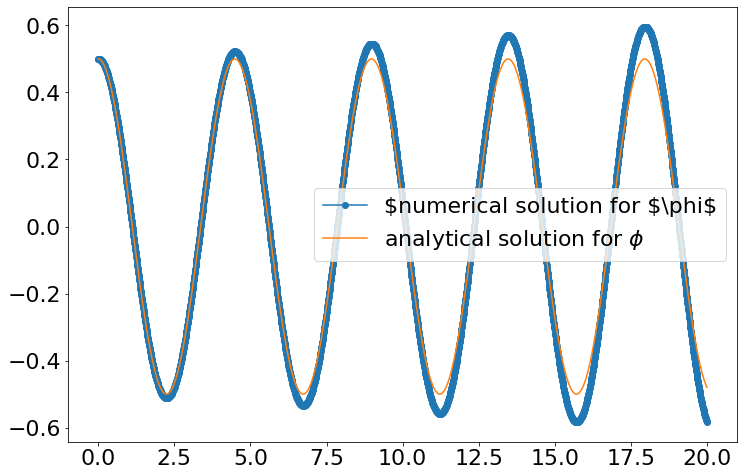

In [145]:
integrate_and_plot(dt=.01, t_final=20)

Our numerical solution looks a lot closer to what it should be using the smaller timestep -- the reason being that we're now approximating only much shorter pieces of the true solution by a straight line, which makes the solution more accurate. But it's still growing over time :(

Let's do it one more time with a tiny timestep -- that looks pretty good now, but it required a lot of timesteps...

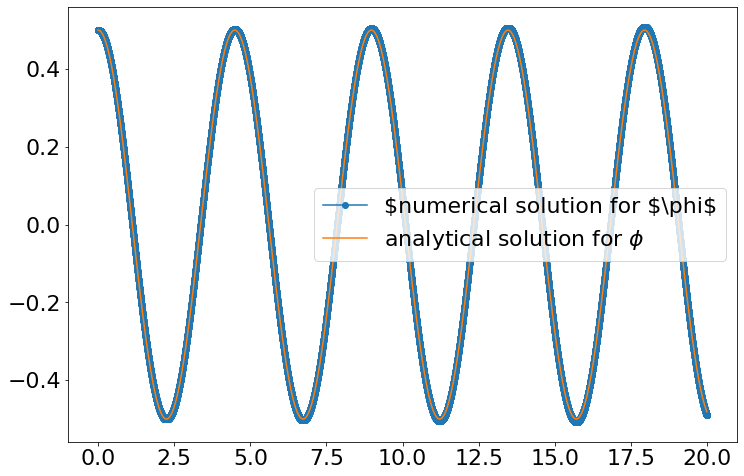

In [146]:
integrate_and_plot(dt=.001, t_final=20)